# Inference: PyMC3

This example shows you how to perform Bayesian inference on a time series, using Pints as an interface of PyMC3 for probabilistic programming.

In [1]:
from __future__ import print_function
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

# PyMC3 setup
import theano
theano.config.compute_test_value = 'raise'
theano.config.exception_verbosity= 'high'
THEANO_FLAGS='floatX=float32,optimizer=fast_compile'
theano.config.floatX = 'float64'
import theano.tensor as tt
from theano.compile.ops import as_op
import pymc3 as pm
from pymc3.step_methods import smc

# Dump files
from tempfile import mkdtemp

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 100000)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Wrap up the forward solution of our model as an as_op
@as_op(itypes=[tt.dvector], otypes=[tt.dmatrix])
def tt_model(param):
    sol = model.simulate(param,times)
    return np.array([sol]).T

# More PyMC3 setup
pymc3_model = pm.Model()
n_steps = 20
n_chains = 100

# SMC!
with pymc3_model:
    # Create a uniform prior over both the parameters and the new noise variable
    prior = pm.Uniform('prior', lower=[0.01,400], upper=[0.02,600], transform=None, shape=model.dimension())
    sigma = pm.Uniform('sigma', lower=noise*0.01, upper=noise*100, transform=None)
    
    mu = tt_model(prior)
    cov = np.eye(1)*sigma**2
    
    # Likelihood
    likelihood = pm.MvNormal('likelihood', mu=mu, cov=cov, observed=np.array([values]).T)
    
    # Dump output
    test_folder = mkdtemp(prefix='SMC_PINTS')
    
    chain = smc.sample_smc(n_steps=n_steps, n_chains=n_chains, progressbar=True,
                           homepath=test_folder, n_jobs=10, 
                           stage=0, tune_interval=5, random_seed=21)



/home/scratch/anaconda3/envs/py2/lib/python2.7/site-packages/pymc3/step_methods/smc.py:480: UserWarning: Warning: SMC is an experimental step method, and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
Argument `step` is None. Auto-initialising step object using given/default parameters.
/home/scratch/anaconda3/envs/py2/lib/python2.7/site-packages/pymc3/step_methods/smc.py:120: UserWarning: Warning: SMC is an experimental step method, and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
Adding model likelihood to RVs!
Init new trace!
Sample initial stage: ...
Beta: 0.000000 Stage: 0
Initialising chain traces ...
Sampling ...
Beta: 0.000012 Stage: 1
Initialising chain traces ...
Sampling ...
Beta: 0.000025 Stage: 2
Initialising chain traces ...
Sampling ...
Beta: 0.000039 Stage: 3
Initialising chain traces ...
Sampling ...
Beta: 0.000059 Stage: 4
Initialising chain traces ...
Sampling ...
Beta: 0.000104 Stage: 5
Initialising chain t

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fde3043a510>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fddfbd2a150>], dtype=object)

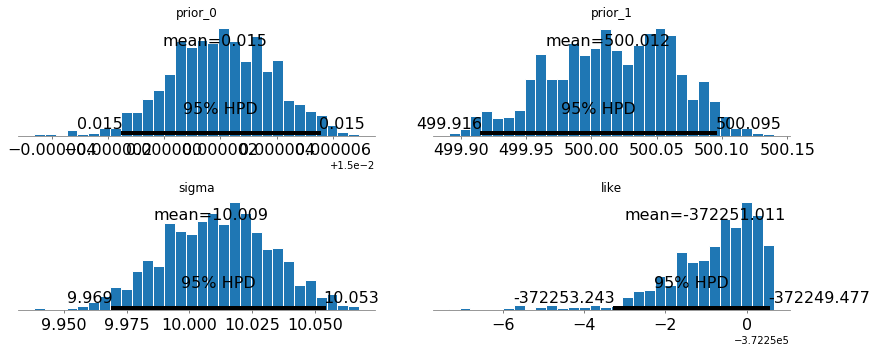

In [3]:
# Plot output
pm.plot_posterior(chain)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdddd44ad50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fdddd159150>]], dtype=object)

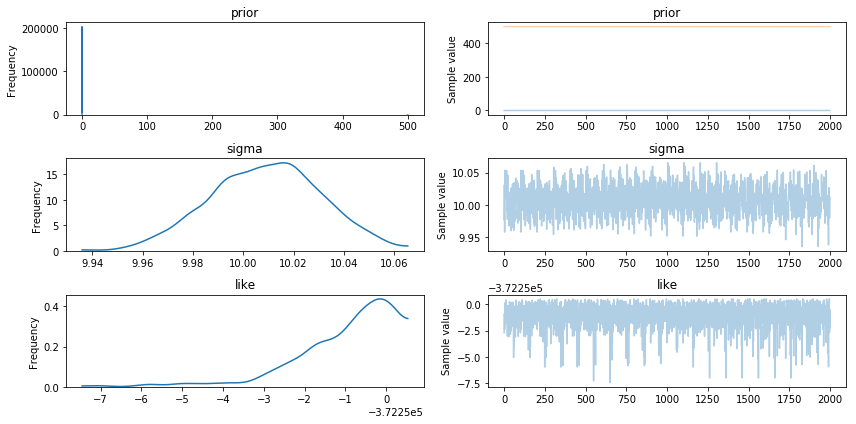

In [4]:
pm.traceplot(chain)

In [5]:
pymc3_model.marginal_likelihood

4.3832348726358011e-10

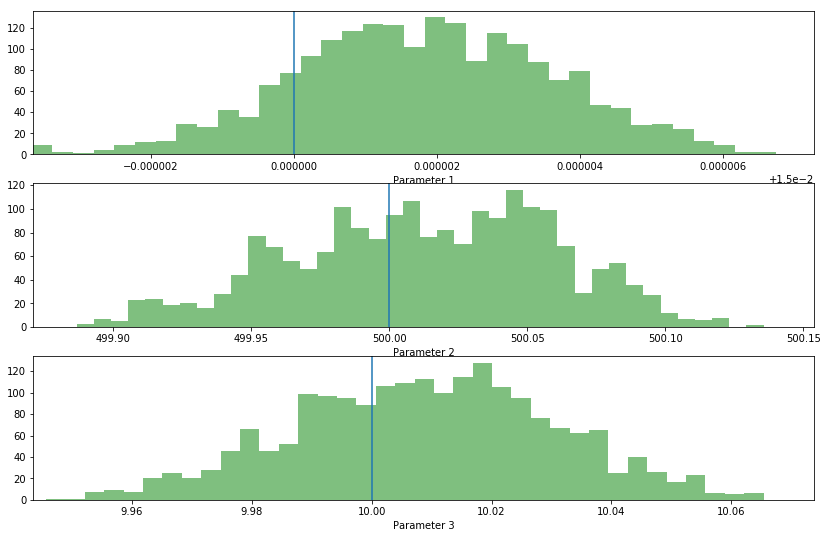

In [6]:
# Get chain as numpy object
from pymc3.plots.utils import get_default_varnames
varname = get_default_varnames(chain.varnames,False)
# add sigma into variable
shape = chain.get_values(varname[0],combine=True, squeeze=True).shape
ourchain = np.zeros((shape[0],shape[1]+1))
ourchain[:,:-1] = chain.get_values(varname[0],combine=True, squeeze=True)
ourchain[:,-1] = chain.get_values(varname[1],combine=True, squeeze=True)

# Do our own plot if we want
# Plot output
pl.figure(figsize=(14, 9))
for i, real in enumerate(real_parameters):
    
    # Add subplot
    pl.subplot(len(real_parameters), 1, 1+i)
    pl.xlabel('Parameter ' + str(i + 1))
    
    # Show true value
    pl.axvline(real)
    
    # Show histogram of chain
    pl.hist(ourchain[:,i], label='p' + str(i + 1), bins=40, color='green',
        alpha=0.5)
    
    # Center plot around mean of chain
    mu = np.mean(ourchain[:,i])
    sigma = np.std(ourchain[:,i])
    pl.xlim(mu - 3 * sigma, mu + 3 * sigma)

pl.show()